In [ ]:
import torch
import timm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import models
import copy
import numpy as numpy
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
# Load dataset
dataset = datasets.ImageFolder(root='Monkeypox Skin Image Dataset', transform=transform)
num_classes = len(dataset.classes)  # Should be 4 for your case
print("num_classes--",num_classes)

In [ ]:
num_clients = 2
client_datasets = random_split(dataset, [len(dataset) // num_clients] * num_clients)

In [ ]:
# Split a small portion for global testing
test_size = int(0.1 * len(dataset))
train_dataset, test_dataset = random_split(dataset, [len(dataset) - test_size, test_size])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

global_model  = models.vgg16(pretrained=True)

# Freeze all VGG16 convolutional layers
for param in global_model.features.parameters():
    param.requires_grad = False
    
# Modify the classifier
global_model.classifier[6] = nn.Linear(4096, num_classes)  # Replace final layer

global_model  = global_model.to(device)

In [ ]:
# Local training function
def local_train(model, train_data, epochs, device):
    model.train()
    loader = DataLoader(train_data, batch_size=32, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

    for _ in range(epochs):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model.state_dict()

In [ ]:
# Federated averaging
def federated_avg(weights_list):
    avg_weights = copy.deepcopy(weights_list[0])
    for key in avg_weights.keys():
        for i in range(1, len(weights_list)):
            avg_weights[key] += weights_list[i][key]
        avg_weights[key] = avg_weights[key] / len(weights_list)
    return avg_weights

In [ ]:
# Evaluation function
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    return acc

In [ ]:
# Federated training loop
accuracy_list = []
num_rounds = 5
local_epochs = 1

for rnd in range(num_rounds):
    print(f"\n--- Federated Round {rnd+1} ---")
    local_weights = []

    for i in range(num_clients):
        print(f"Training on client {i+1}")
        client_model = copy.deepcopy(global_model).to(device)
        client_weights = local_train(client_model, client_datasets[i], local_epochs, device)
        local_weights.append(client_weights)

    # Aggregate with FedAvg
    global_weights = federated_avg(local_weights)
    global_model.load_state_dict(global_weights)

    # Evaluate global model
    acc = evaluate(global_model, test_loader, device)
    accuracy_list.append(acc)
    print(f"Global Model Accuracy after Round {rnd+1}: {acc:.2f}%")

In [ ]:
from sklearn.metrics 
import confusion_matrix
import seaborn as sns

_, y_true, y_pred = evaluate(global_model, test_loader, device, return_preds=True)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


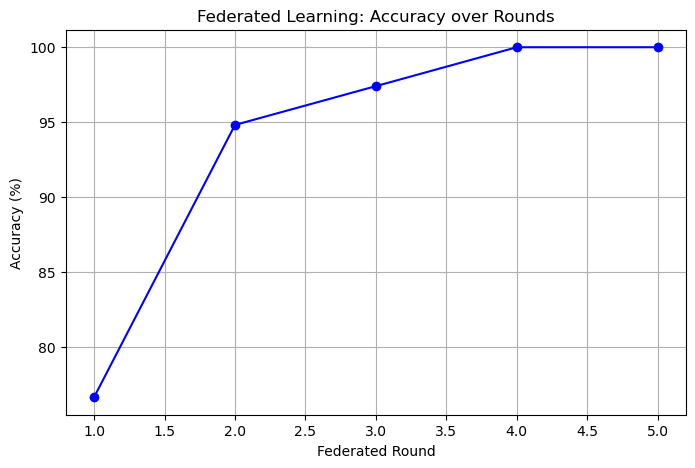

In [3]:
accuracy_list = [ 76.62,94.81,97.40,100.00,100.00]
num_rounds=5
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(range(1, num_rounds+1), accuracy_list, marker='o', color='blue')
plt.title("Federated Learning: Accuracy over Rounds")
plt.xlabel("Federated Round")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()


NameError: name 'evaluate' is not defined